In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Тексты, как и любые другие данные, можно анализировать. Давайте подумаем, какими характеристиками обладают тексты?

1. Статистические характеристики - всё, что можно посчитать:
  * Длина (кол-во символов / кол-во слов / кол-во предложений)
  * Кол-во различных символов / слов / словосочетаний
  * Распределение частей речи в тексте
  * Частота встречаемости терминов
  * Категории, взятые из метаданных
2. Семантические характеристики - всё, что требует "понимания":
  * Смысл текста
  * Контекст за пределами текстовой информации (например, эпоха написания текста; личность автора; упоминание именованных сущностей - лиц, событий, мест). Отсылки
  * Наличие и интерпретация иронии
  * Наличие и интерпретация юмора
  * Тематика
  * Настроение текста

Существует большое количество инструментов, позволяющих анализировать тексты без знания программирования. Это, несомненно, удобно, о таких сервисах полезно знать и пользоваться ими. [Пример.](https://voyant-tools.org/)

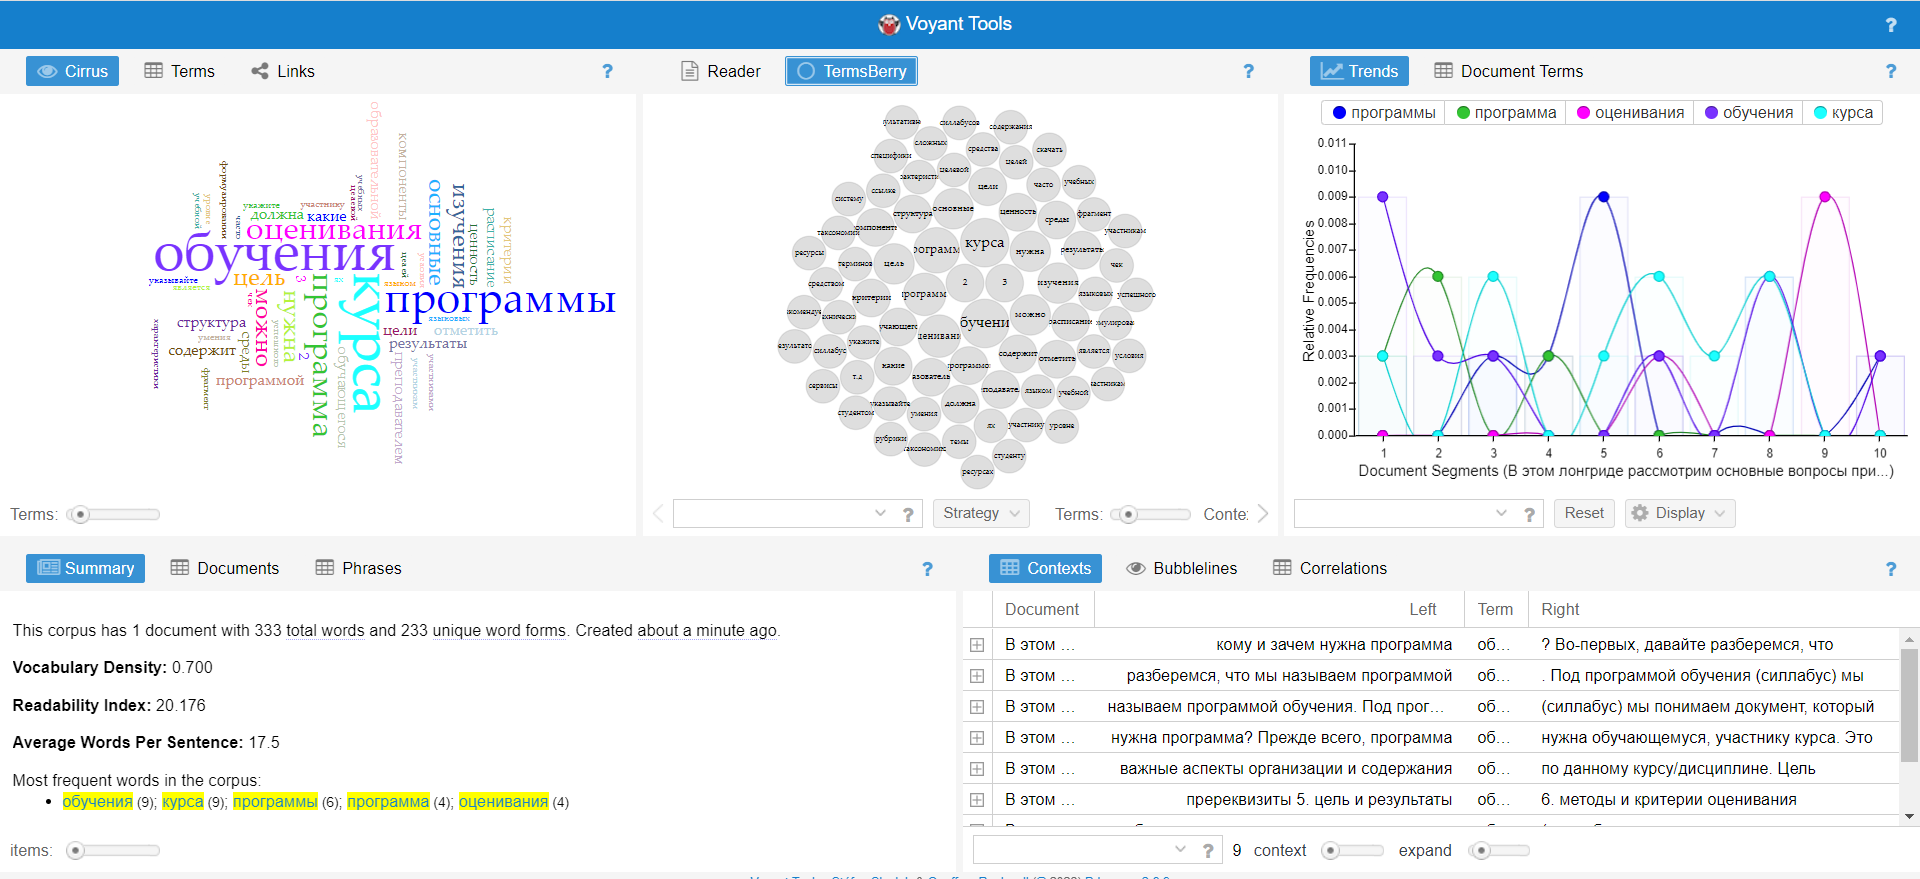

В качестве задания можете найти 2-3 сервиса для анализа текстовых данных, изучить и описать предоставляемые ими возможности и ответить на следующие вопросы:

1. Для решения каких задач можно использовать данные сервисы?
2. Что общего и различного в функционале сервисов? Являются ли различия концептуальными или заключаются в разном визуальном представлении?
3. Предоставляют ли сервисы возможности для кастомизации интерфейса и если да, то какие?

В этом колабе, однако, мы не будем использовать готовые сервисы, а посмотрим на то, как можно анализировать и визуализировать тексты с помощью языка программирования Python.

# Данные

В качестве данных возьмем тексты отзывов на курсы с платформы [Stepik](https://stepik.org/catalog).

In [2]:
%%capture
!pip install neattext natasha pymystem3==0.1.10

In [3]:
%%capture
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import requests
import json
import re
from collections import Counter

from neattext.functions import *
from neattext.pipeline import TextPipeline
from pymystem3 import Mystem
from razdel import tokenize as natasha_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.util import bigrams


mystem = Mystem()

nltk.download('punkt')
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian') + [
'всё', 'это', 'твой', 'свой', 'весь', 'вообще',
'пусть', 'ещё', 'который', 'её', 'словно', 'пока',
'сколько', 'сквозь', 'чей', 'вокруг', 'любой', 'слишком', 'почему',
'среди', 'значит', 'ваш', 'тысяча', 'однажды', 'сегодня',
'завтра', 'вчера', 'послезавтра', 'позавчера', 'нибыть', 'точно',
'уметь', 'целый', 'полный', 'часть', 'делать',
'готовый', 'хотя', 'как', 'столько', 'равно', 'оно', 'похожий',
'скоро', 'разный', 'всякий', 'порой', 'часто', 'настоящий', 'вместо',
'вовсе', 'иметь', 'вроде', 'лишь', 'также', 'млн', 'руб',
'наверное', 'три', 'четыре', 'пять', 'шесть', 'семь', 'восемь',
'девять', 'десять', 'пускай', 'мимо', 'частый', 'сей', 'привет',
'наверно', 'туда', 'иль', 'возможно', 'вено', 'иной', 'едва',
'поэтому', 'впереди', 'зря', 'вообще', 'меж', 'мол', 'нету', 'наш',
'иначе', 'всякий', 'ради', 'оттого', 'нечего', 'скорее',
'пред', 'сначала', 'вряд', 'случайно', 'коль', 'многий', 'кроме',
'откуда', 'нынче', 'ибо', 'порою', 'вне', 'кой', 'еле', 'разом',
'либо', 'зато', 'сорок', 'везде', 'таков', 'вон', 'покуда',
'затем', 'особенно', 'несмотря', 'сотый', 'всюду',
'возле', 'кстати', 'прям', 'ныне', 'бай', 'предельно',
'чрез', 'некий', 'впредь', 'практически', 'лишь', 'каждый',
'день', 'год', 'мочь', 'коли', 'найти', 'нужно', 'снова',
'очень', 'вновь', 'казаться', 'nan']

In [ ]:
# ключ можно получить тут: https://stepik.org/oauth2/applications/ (client type = confidential, authorization grant type = client credentials)

client_id =
client_secret =

# токен
auth = requests.auth.HTTPBasicAuth(client_id, client_secret)
resp = requests.post('https://stepik.org/oauth2/token/', data={'grant_type': 'client_credentials'}, auth=auth)
token = json.loads(resp.text)['access_token']

In [ ]:
def api_call(url: str='https://stepik.org/api/courses/67'):
  answer = json.loads(requests.get(url, headers={'Authorization': 'Bearer '+ token}).text)
  return answer


pages_max = 500
df = pd.DataFrame(columns=['course', 'user', 'score', 'text'])

for page in tqdm(range(1, pages_max)):
    answer = api_call(f"https://stepik.org:443/api/course-reviews?page={page}")
    temp_df = pd.DataFrame(answer['course-reviews'])[['course', 'user', 'score', 'text']]
    df = pd.concat([df, temp_df], ignore_index=True)
    if not answer['meta']['has_next']:
        break

print(len(df))
df.head()

  0%|          | 0/499 [00:00<?, ?it/s]

9780


,course,user,score,text
0,29755,650010668,5,"Понравилось в курсе все, узнала много нового"
1,51269,543260610,5,Хороший материал курса спасибо
2,118842,644302478,5,Ненапряжно и интересно.
3,64633,650548231,5,Класс 💪
4,122957,470313676,5,После курса использую в работе 👍


Немного предобработки.

In [4]:
neattext_pipeline = TextPipeline(steps=[remove_html_tags, remove_urls,
                                        remove_emails, remove_puncts,
                                        remove_numbers])

def simple_preprocessing(text, remove_stopwords=True):
    """
      Простая предобработка текста, состоящая из:
       1) приведения текста к нижнему регистру
       2) удаления html-тэгов, url, email-ов, пунктуации и чисел
       3) лемматизации
       4) удаления стоп-слов
       6) удаления лишних пробельных символов
    """
    step1 = text.lower()
    step2 = re.sub(r"[^-а-яёa-z ]", " ",
                   neattext_pipeline.transform(step1))
    lemmas = mystem.lemmatize(step2)
    if remove_stopwords:
      lemmas = [word for word in lemmas if word not in russian_stopwords]
    step4 = "".join(lemmas).strip()
    step5 = re.sub(r"\s+", " ", step4).strip()
    return step5


def tokenize_text(text):
  return [_.text for _ in natasha_tokenize(text)]

In [ ]:
df['preprocessed_text'] = df['text'].apply(simple_preprocessing)
df.to_csv('/content/drive/MyDrive/Work/NLP 23 24/data/stepik_reviews.csv', index=False)

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Work/NLP 23 24/data/stepik_reviews.csv')
df.fillna('', inplace=True)
df.sample(5)

,course,user,score,text,preprocessed_text
463,132565,624521407,5,очень классный курс! для новичков самое то. сп...,классный курс новичок самый спасибо команда
939,38218,554299261,5,"Хороший курс, понятные объяснения, но очень ма...",хороший курс понятный объяснение мало задание
76,58852,476528823,5,🔥,
8342,75,549306821,5,Настоящее понимание приходит только при решени...,понимание приходить решение задача смысл курс ...
2090,52666,649126533,5,"информация подробная, важная и воистину интере...",информация подробный важный воистину интересный


# Частотный анализ. Эмпирические законы распределения

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

Посмотрим на длину наших текстов.

In [7]:
df['text_len_symbols'] = df.text.apply(len)
df['text_len_symbols'].describe()

count    9780.000000
mean      132.728937
std       219.825304
min         0.000000
25%        18.000000
50%        57.000000
75%       158.000000
max      5569.000000
Name: text_len_symbols, dtype: float64

In [8]:
hist = go.Histogram(x=df['text_len_symbols'], marker=dict(color='cornflowerblue', opacity=0.9))

fig = go.Figure(hist)

fig.update_layout(
    title='Длина текстов в символах',
    xaxis=dict(title='Длина текста'),
    yaxis=dict(title='Частота'),
    showlegend=False
)

fig.show()

Тексты содержат информацию о категориях. Обычно, если для текстовой информации известны метаданные, имеет смысл строить визуализации по каждой группе отдельно.

In [9]:
fig = px.bar(df.groupby('score').count()['text'], color_discrete_sequence=['cornflowerblue'])

fig.update_layout(
    title="Люди не скупятся на положительные отзывы",
    xaxis_title="Рейтинг",
    yaxis_title="Кол-во отзывов",
    xaxis=dict(categoryorder='total ascending'),
    showlegend=False
)

fig.update_traces(textposition='outside')

fig.show()

In [10]:
text_count = df.groupby('score')['text_len_symbols'].count().reset_index()
fig = px.box(df, x='score', y='text_len_symbols',
             color_discrete_sequence=["cornflowerblue"])

for i, row in text_count.iterrows():
    fig.add_annotation(
        text='Всего текстов: ' + str(row['text_len_symbols']),
        x=row['score'],
        y=max(df['text_len_symbols']),
        showarrow=False,
        font=dict(size=12),
        yshift=50
    )

fig.update_layout(
    title="Когда всё понравилось, сказать нечего",
    xaxis_title="Рейтинг",
    yaxis_title="Кол-во символов",
    xaxis=dict(categoryorder='total ascending'),
    showlegend=False
)
fig.show()

Теперь поговорим про законы распределения. Законы распределения – это статистические закономерности, которые описывают, как распределяются данные (слова, фразы или языковых структуры) в больших объемах текста.


**Закон Ципфа**: Этот закон описывает частоту встречаемости слов в тексте. Он утверждает, что наиболее часто встречающееся слово в тексте встречается вдвое чаще, чем второе по частоте слово, третье слово - вдвое реже второго, и так далее. Формула, описывающая этот закон, выглядит следующим образом:

   **f(w) = C / r**

   Где:
   - **f(w)** - частота встречаемости слова **w**,
   - **r** - ранг слова (порядковый номер в списке слов по убыванию частоты),
   - **C** - константа.


   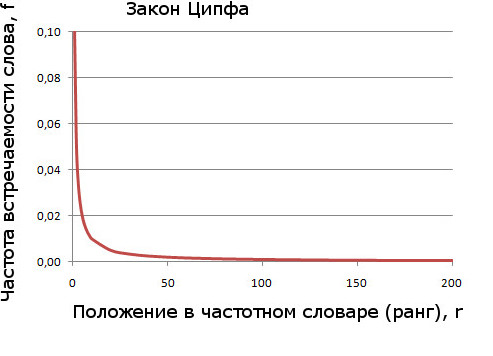

In [11]:
freqs = Counter(tokenize_text(' '.join(df.preprocessed_text)))
ranked_words = sorted(freqs.items(), key=lambda x: x[1], reverse=True)
mx = freqs.most_common(1)[0][1]
ranks, frequencies = zip(*enumerate([freq / mx for word, freq in ranked_words], 1))
ranked_words = [word for word, freq in ranked_words]
data = pd.DataFrame({'Rank': ranks, 'Frequency': frequencies, 'Word': ranked_words})

fig = px.line(data, x='Rank', y='Frequency', markers=True, hover_name='Word',
              color_discrete_sequence=["cornflowerblue"])
fig.update_xaxes(type='linear')
fig.update_yaxes(type='linear')
fig.update_layout(
    title="Закон Ципфа",
    xaxis_title='Ранг',
    yaxis_title='Частота'
)

**Закон Хипса**: Этот закон связан с размером словаря текста. Он утверждает, что размер словаря (количество уникальных слов) растет с увеличением длины текста, но не так быстро. Закон Хипса можно описать следующей формулой:

   **V(n) = K * n^b**

   Где:
   - **V(n)** - размер словаря при тексте длиной **n** слов,
   - **K** - константа,
   - **b** - коэффициент, обычно около 0.5.


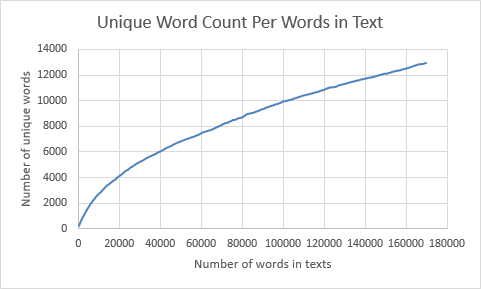

In [12]:
df['preprocessed_text_len'] = df['preprocessed_text'].apply(len)
df = df.sort_values('preprocessed_text_len')
df['nunique_words'] = df['preprocessed_text'].apply(lambda text: len(set(tokenize_text(text))))
fig = px.line(df, x='preprocessed_text_len', y='nunique_words',
              markers=True, color_discrete_sequence=["cornflowerblue"])
fig.update_xaxes(type='linear')
fig.update_yaxes(type='linear')
fig.update_layout(
    title="Закон Хипса",
    xaxis_title='Кол-во слов',
    yaxis_title='Кол-во уникальных слов'
)
fig.show()

Интересный выброс.

In [13]:
df[df['preprocessed_text_len'] == 1172]

,course,user,score,text,preprocessed_text,text_len_symbols,preprocessed_text_len,nunique_words
1314,170896,424859428,1,Добыча торфа\nДобыча песка\nДобыча золота\nГео...,добыча торф добыча песок добыча золото геолого...,1207,1172,7


Удалим его.

In [14]:
df = df[df['preprocessed_text_len'] != 1172]

**Закон Брэдфорда**: Этот закон описывает распределение частоты слов в тексте по их значимости. Согласно закону Брэдфорда, небольшое количество слов (называемых "ключевыми словами") составляют большую часть текста. Эти ключевые слова могут быть общими для многих текстов и несут основной смысл.

   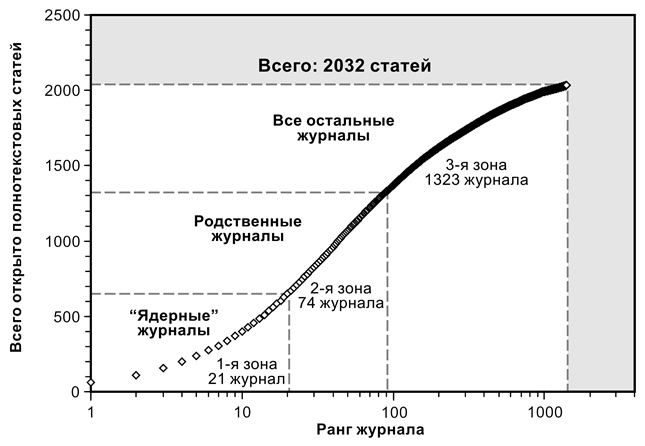

Проблема: ключевые слова или стоп-слова?

In [15]:
def plot_top_terms_and_bigrams(df, text_column, title):
    df['text_tokens'] = df[text_column].apply(tokenize_text)
    top_N = 15

    all_tokens = [token for tokens in df['text_tokens'] for token in tokens]
    token_freqs = Counter(all_tokens)
    most_common_tokens = token_freqs.most_common(top_N)
    terms, frequencies = zip(*most_common_tokens)
    data = pd.DataFrame({'Term': terms, 'Frequency': frequencies})

    all_bigrams = [bigram for tokens in df['text_tokens'] for bigram in bigrams(tokens)]
    bigram_freqs = Counter(all_bigrams)
    most_common_bigrams = bigram_freqs.most_common(top_N)
    bigram_terms, bigram_frequencies = zip(*most_common_bigrams)
    bigram_data = pd.DataFrame({'Bigram': [' '.join(bigram) for bigram in bigram_terms], 'Frequency': bigram_frequencies})

    fig_tokens = px.bar(data.sort_values('Frequency'), x='Frequency', y='Term', orientation='h', color_discrete_sequence=["cornflowerblue"])
    fig_tokens.update_layout(
        xaxis_title='Частота',
        yaxis_title='Слово'
    )

    fig_bigrams = px.bar(bigram_data.sort_values('Frequency'), x='Frequency', y='Bigram', orientation='h', color_discrete_sequence=["lightgrey"])
    fig_bigrams.update_layout(
        xaxis_title='Частота',
        yaxis_title='Биграм'
    )

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Униграммы", "Биграммы"))
    fig.add_trace(fig_tokens.data[0], row=1, col=1)
    fig.add_trace(fig_bigrams.data[0], row=1, col=2)
    fig.update_layout(title_text=title, showlegend=False)
    fig.show()

In [16]:
plot_top_terms_and_bigrams(df, 'text', "Топ-15 частых слов и биграм для исходных текстов")
plot_top_terms_and_bigrams(df, 'preprocessed_text', "Топ-15 частых слов и биграм для предобработанных текстов")

В предыдущем коде используются "униграммы" и "биграммы". Они являются частными случаями N-грамм. N-граммы - это последовательности из N элементов. Они могут представлять собой символы, слова или целые фразы.

Их можно использовать для многих задач. Например, для определения языка текста; для поиска устойчивых выражений и словосочетаний; для построения модели грамматики языка. Подумайте, как именно.

In [17]:
sentence = """N-граммы - это последовательности из N элементов"""
words = sentence.split()
print("Униграммы:", words)
bigrams_ = [(words[i], words[i + 1]) for i in range(len(words) - 1)]
print("Биграммы:", *bigrams_)
trigrams = [(words[i], words[i + 1], words[i + 2]) for i in range(len(words) - 2)]
print("Триграммы:", *trigrams)

Униграммы: ['N-граммы', '-', 'это', 'последовательности', 'из', 'N', 'элементов']
Биграммы: ('N-граммы', '-') ('-', 'это') ('это', 'последовательности') ('последовательности', 'из') ('из', 'N') ('N', 'элементов')
Триграммы: ('N-граммы', '-', 'это') ('-', 'это', 'последовательности') ('это', 'последовательности', 'из') ('последовательности', 'из', 'N') ('из', 'N', 'элементов')


# Визуализация текстовых данных

In [18]:
%%capture
!pip install scattertext
!python -m spacy download ru_core_news_sm

In [19]:
from PIL import Image
from io import BytesIO
from wordcloud import WordCloud
from IPython.display import HTML
import spacy
import scattertext as st

Самая базовая визуализация, которую можно создать, - облако слов.

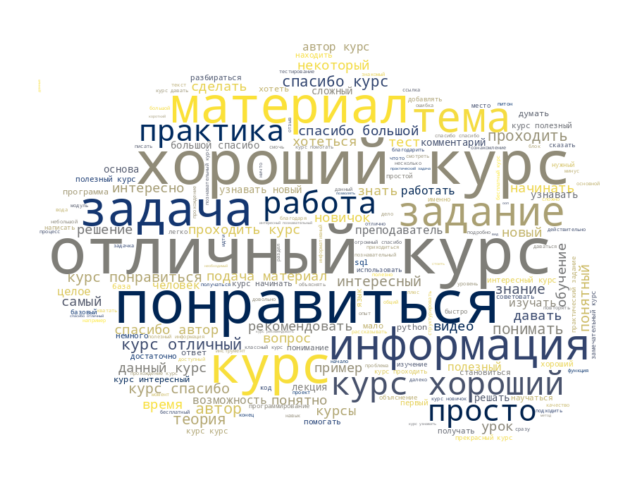

In [20]:
url = "https://www.pinclipart.com/picdir/middle/519-5194083_cloud-clipart.png"  # взято у Чернышевой А.В.
response = requests.get(url)
cloud_mask = np.array(Image.open(BytesIO(response.content)))

text = ' '.join(df['preprocessed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      mask=cloud_mask, colormap='cividis').generate(text)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Посмотрим на облака слов для разных оценок. Как вы считаете, какие слова можно назвать стоп-словами в контексте работы с отзывами на курсы?

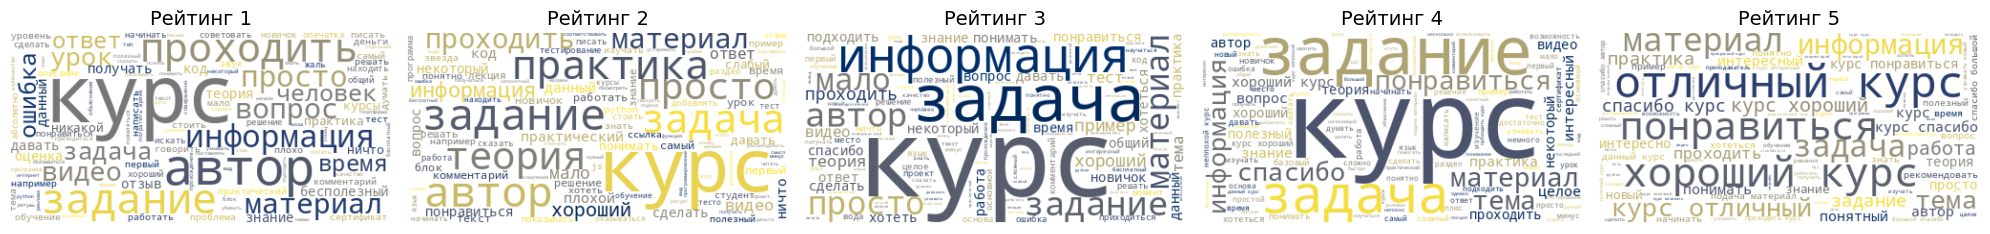

In [21]:
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

ctgs = df.score.unique()
ctgs.sort()

fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    axes[i].set_title("Рейтинг " + str(ctgs[i]), fontsize=14)

    descr = ' '.join(df[df.score == ctgs[i]]['preprocessed_text'].astype(str).values)
    cloud_descr = WordCloud(background_color='white',
                            collocations=True, max_words=200,
                            colormap="cividis").generate(descr)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    remove_spines(axes[i])
    axes[i].imshow(cloud_descr, interpolation="bilinear")

plt.tight_layout()
plt.show()

Также взглянем на библиотеку [scattertext](https://github.com/JasonKessler/scattertext). Она предоставляет множество возможностей для визуализации текстовых данных, более подробно можно почитать в документации.

Данная библиотека ориентирована на работу с текстами, разделенными на две категории (positive vs negative), поэтому приведем отзывы к соответствующему формату. Будем считать рейтинг 1-3 плохим, а 4-5 хорошим.

In [22]:
st_df = df[['score', 'text', 'preprocessed_text']]
st_df['score'] = st_df.score.apply(lambda rt: 'negative' if rt < 4 else 'positive')

<ipython-input-22-bd1fe5f00323>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
nlp = spacy.load("ru_core_news_sm")

corpus = st.CorpusFromPandas(st_df, category_col='score',
                             text_col='preprocessed_text',
                             nlp=nlp).build()

html = st.produce_scattertext_explorer(
    corpus,
    category='negative',
    category_name='Рейтинг 1-3',
    not_category_name='Рейтинг 4-5',
    width_in_pixels=1000,
)

HTML(html)

Output hidden; open in https://colab.research.google.com to view.

Другие примеры интересных визуализаций текстовых данных можно найти [здесь](https://textvis.lnu.se/).

# Графовая модель корпуса

Граф - это структура данных, сосотящая из множества вершин и связывающих их рёбер.

При построении графовой модели корпуса текстов вершинами могут быть различные слова (кол-во появлений определяет размер вершины), а ребрами - то, как часто слова встречаются рядом друг с другом в рамках корпуса (биграммы).

In [24]:
%%capture
!pip install pyvis

In [25]:
import sqlite3
import scipy
import networkx as nx
import community.community_louvain as community_louvain
from pyvis.network import Network

In [26]:
def text_pairs(data_token):
  words = []
  for i in range (len(data_token)):
      text = data_token.iat[i, 1]
      tokens = tokenize_text(text)
      bigrams = list(nltk.bigrams(tokens))
      bi_cats = []
      for j in bigrams:
          j = list(j)
          j.append(data_token.iat[i, 2])
          bi_cats.append((j[0], j[1], j[2]))
      words += bi_cats
  print(len(words))
  return words


def create_graph(graph_data):
    G = nx.from_pandas_edgelist(graph_data,
                            source = "source",
                            target = "target",
                            edge_attr = "value",
                            create_using = nx.Graph())

    comm = community_louvain.best_partition(G)

    net = Network(notebook=True, cdn_resources='in_line', width="1000px",
                  height="700px", bgcolor='#222222', font_color='white')

    node_degree = dict(G.degree)
    nx.set_node_attributes(G, node_degree, 'size')
    nx.set_node_attributes(G, comm, 'group')

    net.from_nx(G)
    net.show('graph.html')
    display(HTML('graph.html'))

In [27]:
words = text_pairs(df[['text', 'preprocessed_text', 'score']].astype(str))
words[:5]

105426


[('х', 'ета', '1'),
 ('a', 'bit', '4'),
 ('its', 'ok', '5'),
 ('not', 'bad', '4'),
 ('jaime', 'a', '4')]

SQL в данном случае используется исключительно для ускорения расчетов по таблице.

In [28]:
con = sqlite3.connect(":memory:")
cur = con.cursor()
cur.execute("CREATE TABLE review (id, word_a, word_b, cat);")
for i in range(len(words)):
  cur.execute("INSERT INTO review (id, word_a, word_b, cat) VALUES (?, ?, ?, ?);",
                                        (i, words[i][0], words[i][1], words[i][2]))
con.commit()

cur.execute("SELECT word_a, word_b, COUNT(*) AS cnt " \
            "FROM review " \
            "GROUP BY word_a, word_b " \
            "ORDER BY cnt " \
            "DESC;")
occ = cur.fetchall()

weighted_pairs = []
for row in occ:
    weighted_pairs.append((row[0], row[1], row[2]))
data_weighted_pairs = pd.DataFrame(weighted_pairs, columns =['source', 'target', 'value'])
data_w_p_100 = data_weighted_pairs.head(100)

create_graph(data_w_p_100)

graph.html


# Тематическое моделирование

Тематическое моделирование - это задача кластеризации текстовых данных. Машинное обучение без учителя, то есть все шаги, кроме задания гиперпараметров и интерпретации результатов, отдаются на откуп алгоритму. Подход к задачам кластеризации следующий:

1. Выделим значимые признаки у объектов
2. Проведем векторизацию (перевод в числовой формат) объектов на основании выделенных признаков
3. Посчитаем расстояния между объектами
4. Определим, какие расстояния соответствуют понятиям "далеко" и "близко"
5. Примем решение о количестве кластеров на основании посчитанных расстояний
6. Проинтерпретируем полученные кластеры

Существует несколько основных алгоритмов тематического моделирования. Например, LSA, pLSA, LDA (с отдельной библиотекой для визуализации LDAVis), BigARTM и другие. [Неплохая статья](https://towardsdatascience.com/topic-modeling-with-lsa-plsa-lda-nmf-bertopic-top2vec-a-comparison-5e6ce4b1e4a5) про алгоритмы.

В данном колабе мы посмотрим на [topic-wizard](https://github.com/x-tabdeveloping/topicwizard) - одну из библиотек для визуализации результатов тематического моделирования.

In [29]:
%%capture
!pip install topic-wizard  # need to restart runtime after this

Но прежде чем говорить про topic-wizard, придется сказать пару слов про [ngrok](https://dashboard.ngrok.com/). Причина в том, что topic-wizard создает plotly-dash приложение, которое прекрасно запускается локально, но чтобы запустить его из колаба, нужно постараться.

Ngrok - это сервис, который предоставляет возможность создания временных и безопасных туннелей между локальным компьютером или локальным сервером и общедоступной сетью. Он предоставляет временный публичный URL для локального веб-приложения.

Чтобы использовать ngrok, потребуется создать бесплатный аккаунт на сайте.

In [30]:
%%capture
!pip install pyngrok

In [46]:
import getpass
from pyngrok import ngrok, conf

print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()

port = "8050"
public_url = ngrok.connect(port).public_url
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········


 * ngrok tunnel "https://cc2c-104-197-242-81.ngrok-free.app" -> "http://127.0.0.1:8050"


Чтобы запустить код с помощью ngrok, нужно записать скрипт в отдельный .py файл и запустить. Все данные можно передать через файлы, лежащие в той же директории.

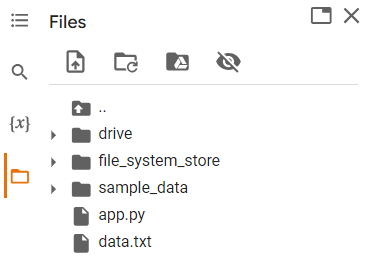

In [32]:
with open('data.txt', 'w') as file:
  file.write(str(df.preprocessed_text.tolist()))

In [33]:
%%writefile app.py

import topicwizard
from sklearn.decomposition import NMF  # non-negative matrix factorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline


vectorizer = CountVectorizer(min_df=10, max_df=0.7)  # Bag of Words
topic_model = NMF(n_components=10)  # 10 кластеров
topic_pipeline = Pipeline(
    [
        ("vectorizer", vectorizer),
        ("topic_model", topic_model),
    ]
)

with open('data.txt', 'r') as file:
  corpus = eval(file.read())

topic_pipeline.fit(corpus)

topicwizard.visualize(pipeline=topic_pipeline, corpus=corpus)

Writing app.py


In [ ]:
!python app.py

Что получается:

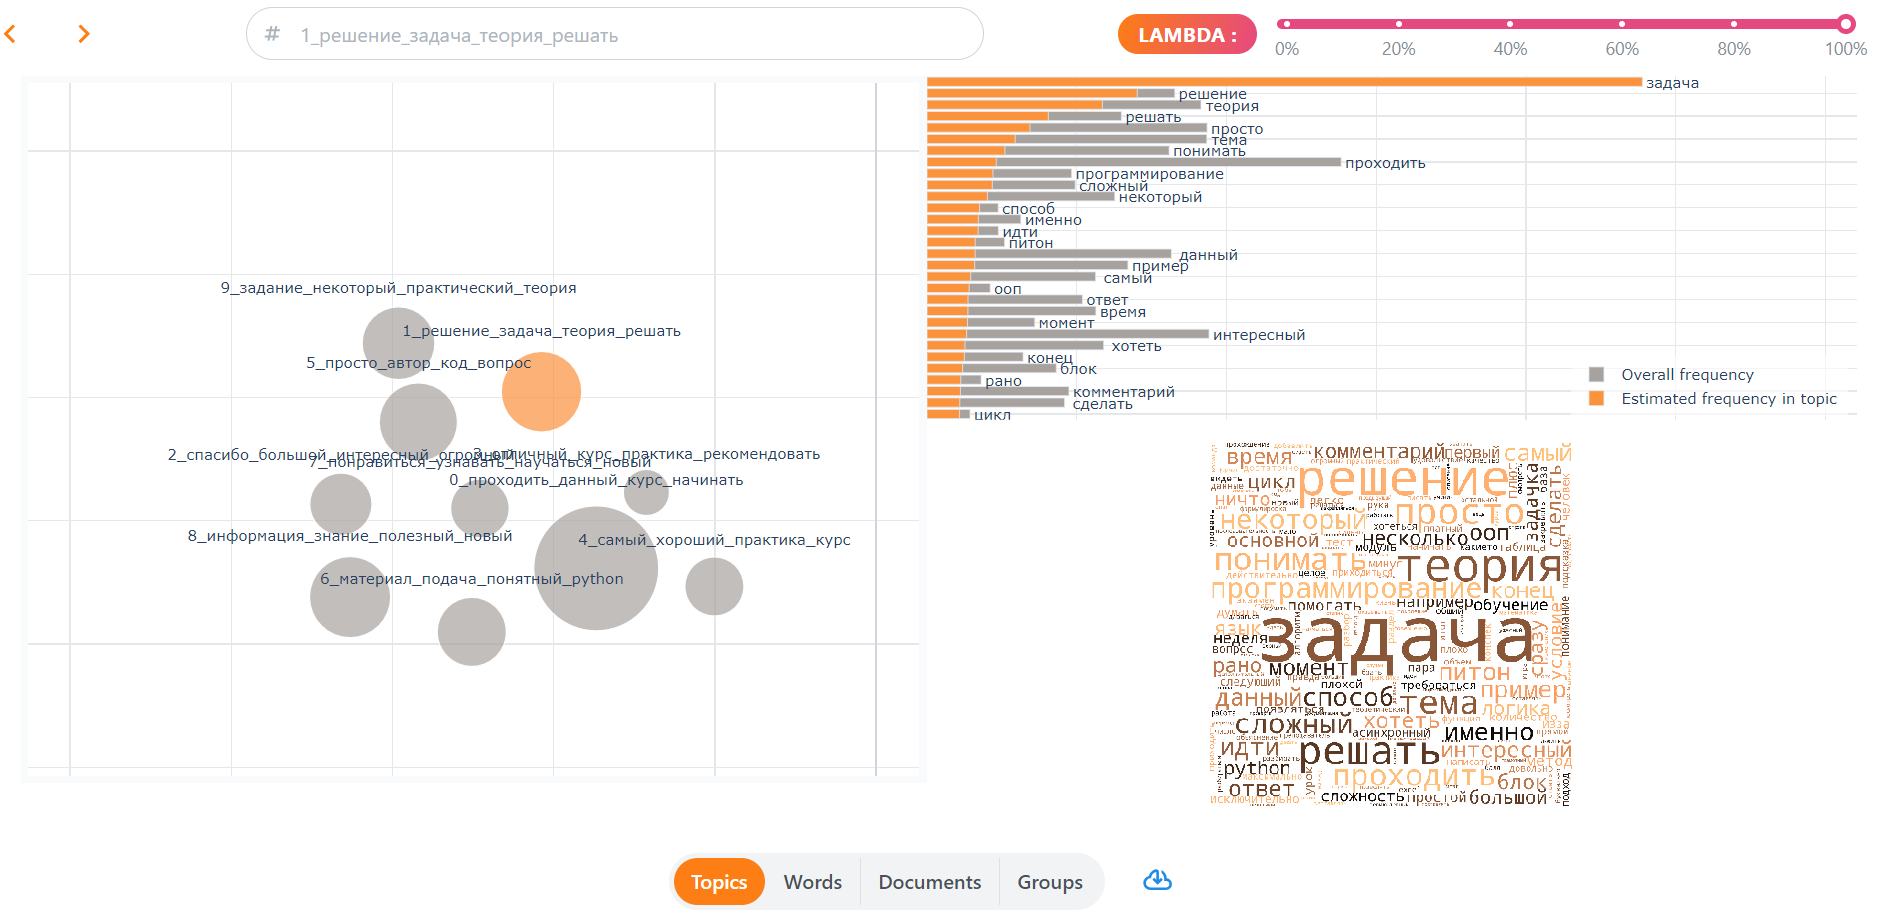

# Анализ тональности

Рассмотрим еще одну задачу, которую часто приходится решать на этапе анализа данных.

Анализ тональности (Sentiment Analysis) - это задача классификации, когда мы заранее знаем метки класса, и алгоритм должен решить, к какому классу отнести новый объект.

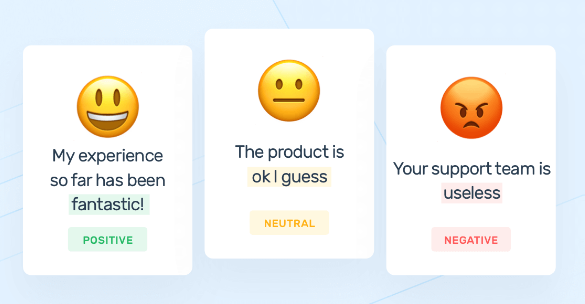

Подумайте, зачем может быть полезно понимать, какую тональность имеет текст? Для решения каких задач можно использовать подобную информацию?

Для анализа тональности удобно использовать предобученные модели. Для русского языка, например, существует библиотека [dostoevsky](https://github.com/bureaucratic-labs/dostoevsky).

In [35]:
%%capture
!pip install dostoevsky
!python -m dostoevsky download fasttext-social-network-model

In [36]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

In [37]:
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)  # предобученная модель

В качестве результата возвращаются метки классов и то, насколько модель уверена, что текст можно отнести к соответствующему классу. Обратите внимание, что это не объективная вероятность принадлежности к классу, а субъективное мнение модели!

In [38]:
sentiment_scores = model.predict(["Какой замечательный день!"])[0]
print(max(sentiment_scores, key=sentiment_scores.get))
sentiment_scores

positive


{'positive': 0.994455099105835,
 'negative': 0.02596735954284668,
 'neutral': 0.0071314298547804356,
 'skip': 0.006299902219325304,
 'speech': 0.004765199031680822}

In [39]:
df['score_pred'] = list(map(lambda pred: max(pred, key=pred.get), model.predict(df.text)))

In [40]:
value_counts = df.score_pred.value_counts()
data = pd.DataFrame({'Labels': value_counts.index, 'Counts': value_counts.values})

fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=data['Labels'],
        values=data['Counts'],
        textinfo='percent+label',
        marker_colors=px.colors.sequential.Blues[2:],
    )
)

fig.update_layout(
    width=600,
    title="Предсказания модели",
    showlegend=False,
)
fig.show()

Посмотрим на предсказания модели по каждой категории. Какую проблему вы можете заметить?

In [41]:
grouped_df = df.groupby(['score', 'score_pred']).size().reset_index(name='count')
labels = ['negative', 'neutral', 'positive', 'speech', 'skip']
colormap = px.colors.sequential.Blues[:8][::-1]

fig = px.bar(grouped_df, x='score', y='count', color='score_pred',
             title='Предсказания модели в каждой из категорий',
             labels={'score_pred': 'Score Prediction', 'count': 'Count'},
             color_discrete_map={label: colormap[i] for i, label in enumerate(labels)})

fig.show()

# Задание

## Частотный анализ

Вашей задачей будет написать алгоритм для определения языка текста для следующей выборки языков: de (немецкий), en (английский), es (испанский), fr (французский), it (итальянский), ru (русский). Для этого воспользуемся идеей подсчета посимвольных n-грамм.

Загрузите данные. Пожалуйста, не меняйте ничего в следующем коде.

In [42]:
%%capture
!pip install datasets

In [43]:
from datasets import load_dataset

dataset = load_dataset("papluca/language-identification")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split


languages_to_keep = ['de', 'en', 'es', 'fr', 'it', 'ru']  # только нужные языки

train_dataset = dataset["train"]
train_df = pd.DataFrame(train_dataset)
train_data_filtered = train_df[train_df['labels'].isin(languages_to_keep)]

train_data, test_data = train_test_split(train_data_filtered, train_size=8000,
                                         test_size=2000, random_state=42,
                                         stratify=train_data_filtered['labels'])  # train и test

training_data = {}  # формат тренировочных данных {язык: [тексты]}
for _, row in train_data.iterrows():
    lang = row['labels']
    text = row['text']
    if lang not in training_data:
        training_data[lang] = []
    training_data[lang].append(text)

test_data.head()  # как выглядят тестовые данные

,labels,text
37672,de,Katze umgeht es. Der Geruch nach Chemie ist se...
69341,de,Super. Pünktlich geliefert
35296,ru,"Мы больше не можем делать это за $ 20 , сказал..."
30150,es,A mi tambien se me ha pinchado una rueda y no ...
19832,en,Very nice. Light weight and they look so much ...


Допишите класс, реализуйющий алгоритм детекции языка.

In [ ]:
import nltk
from nltk.util import ngrams
from collections import Counter
from sklearn.metrics import classification_report


class LanguageDetector:
    def __init__(self, n_values=[1, 2, 3, 4]):
        self.n_values = n_values  # значения n для расчета n-грамм
        self.lang_ngram_dict = {}  # словарь, где будут храниться n-граммы для каждого языка

    def clean(self, text):
        # опциональная функция для предобработки текста
        pass

    def count_ngrams(self, text, n):
        # посчитайте вероятности (частоты встречаемости) n-грамм
        # предполагаемый формат: {n-gramm: probability},
        # где вероятность равна отношению кол-ва той или иной n-граммы к суммарному кол-ву n-грамм
        return ngram_probabilities

    def train(self, training_data):
        # заполните self.lang_ngram_dict
        # предполагаемый формат: {language: {n-gramm: probability}}
        # используйте функцию count_ngrams
        # для удабства работы список текстов для одного языка можно соединить в единый текст
        pass

    def predict(self, text):
        if not self.lang_ngram_dict:
            raise ValueError("Language model not trained. Use train method to train the model.")
        # посчитайте n-граммы для текста с помощью функции count_ngrams
        # вычислите расстояние между n-граммами текста и n-граммами для каждого из языков
        # в качестве функции потерь можно взять MAE или MSE
        # выберите тот язык, расстояние до которого окажется наименьшим
        return detected_language

In [ ]:
detector = LanguageDetector()

detector.train(training_data)  # обучение алгоритма
detector.predict("The output must be 'en'")  # предсказание для одного текста

'en'

Вы должны получить accuracy не меньше 90%. Напомню, что accuracy считается как отношение верно угаданных меток класса к размеру выборки.

In [ ]:
detected_languages = [detector.predict(input_text) for input_text in test_data['text']]  # предсказания для всего тестового набора
test_data['preds'] = detected_languages
print(classification_report(test_data['labels'], test_data['preds']))

              precision    recall  f1-score   support

          de       0.97      0.99      0.98       333
          en       0.98      0.95      0.96       333
          es       0.95      0.97      0.96       333
          fr       0.95      0.97      0.96       334
          it       0.96      0.94      0.95       334
          ru       1.00      0.99      1.00       333

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



Сравните то, что получилось у вас, со следующей библиотекой.
Параметры для сравнения:
* качество
* скорость работы
* кол-во поддерживаемых языков
* удобство использования

In [ ]:
%%capture
!pip install langdetect

In [ ]:
from langdetect import detect

detect("The output must be 'en'")

'en'

За данную работу можно получить максимум 12 баллов.

## Визуализация

Возьмем корпус русскоязычных текстов про лекарственные препараты [отсюда](https://github.com/natasha/corus). Он не очень большой.

In [ ]:
%%capture
!pip install corus
!wget https://github.com/cimm-kzn/RuDReC/raw/master/data/rudrec_annotated.json

In [ ]:
from corus import load_rudrec

path = 'rudrec_annotated.json'
texts = [record.text for record in load_rudrec(path)]
len(texts)

4809

Ваша задача - построить по корпусу два вида визуализаций:

1. Облако слов
2. Граф

Вы можете использовать код из данного колаба или любой другой, найденный в интернете. Не забудьте про предобработку текста!

Проанализируйте полученные результаты. Какую информацию можно извлечь из получившихся у вас графиков?

Вы можете собрать свой корпус или использовать готовый. Главное, чтобы тексты были на русском языке, а их количество составляло не менее 3000.

За работу с готовым корпусом из corus про лекарства (или любой другой питоновской библиотеки) можно максимально получить 10 баллов, за работу со своим корпусом - 14.